# Spatial Trascriptomics analysis

This tutorial will cover processing and basic analysis of Spatial Trascriptomics (10X Visium HD) data:
- quality control (QC)
- normalization
- spatially variable genes
- clustering
- spatial deconvolution
- neighborhood analysis

Info on datatypes provided by 10X: https://www.10xgenomics.com/support/software/space-ranger/latest/analysis/outputs/output-overview

The three most commonly used frameworks for spatial trascriptomics analysis are Scanpy, Squidpy and Seurat, for additional tutorials see the following links:
- Scanpy (Python) https://scanpy-tutorials.readthedocs.io/en/latest/
- Squidpy (Python) https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/
- Seurat (R) https://satijalab.org/seurat/articles/spatial_vignette/

For additional informations and suggestions on spatial trascriptomics analysis, see:
- Single-cell best practices https://www.sc-best-practices.org/spatial/introduction.html

For this tutorial, we will focus on Scanpy and other python tools. Information on Scanpy tools and their parameters can be found here: https://scanpy.readthedocs.io/en/stable/ 

### Create working directory

First, set up a output directory where you will save your data and results files:

In [1]:
import os

outdir = "/dodrio/scratch/projects/2024_301/Spatial-Omics-Data-Analysis/" + os.environ['USER'] + "/test1/"
os.makedirs(outdir, exist_ok=True)

## 10X Visium Colorectal Cancer data set

From paper: High-definition spatial transcriptomic profiling of immune cell populations in colorectal cancer

Datasets: https://www.10xgenomics.com/platforms/visium/product-family/dataset-human-crc

https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/what-is-space-ranger

#### Finding a new dataset

If you want to make a project with Spatial Transcriptomics data, we recommend to look for **publications** analyzing this type of data. In the paper's *Data availability* section, they will indicate where they have deposited the data (e.g. [GEO](https://www.ncbi.nlm.nih.gov/geo/), or an alternative repository).

In addition, here we provide a list of useful databases storing Spatial Trascriptomics datasets with relative publications:
- https://db.cngb.org/stomics/
- http://www.spatialomics.org/SpatialDB/
- https://aquila.cheunglab.org/view
- https://docs.google.com/spreadsheets/d/1sJDb9B7AtYmfKv4-m8XR7uc3XXw_k4kGSout8cqZ8bY/edit?usp=sharing

## Data loading

For this tutorial, we start from 10X Space Ranger output. We copied the essential Space Ranger output files of a sample to:

`/mnt/storage/nhecker/data/spatial/VisiumHD`

Let's have a look at the files:

In [2]:
import os

path_data = "/dodrio/scratch/projects/2024_301/Spatial-Omics-Data-Analysis/data/CRC/"

os.listdir(path_data)

['Visium_HD_Human_Colon_Cancer_P5_probe_set.csv',
 'Visium_HD_Human_Colon_Normal_P5_alignment_file.json',
 'Visium_HD_Human_Colon_Cancer_P2_molecule_info.h5',
 'Visium_HD_Human_Colon_Normal_P5_metrics_summary.csv',
 'Visium_HD_Human_Colon_Cancer_P1_molecule_info.h5',
 'Visium_HD_Human_Colon_Normal_P5_tissue_image.btf',
 'Visium_HD_Human_Colon_Cancer_P1_feature_slice.h5',
 'Visium_HD_Human_Colon_Normal_P3_feature_slice.h5',
 'Visium_HD_Human_Colon_Cancer_P5_binned_outputs.tar.gz',
 'readme.txt',
 'spatial',
 'Visium_HD_Human_Colon_Normal_P3_slide_file.vlf',
 'Visium_HD_Human_Colon_Cancer_P2_image.tif',
 'Visium_HD_Human_Colon_Cancer_P1_binned_outputs.tar.gz',
 'Visium_HD_Human_Colon_Normal_P3_image.tif',
 'Visium_HD_Human_Colon_Cancer_P1_spatial.tar.gz',
 'Visium_HD_Human_Colon_Cancer_P2_probe_set.csv',
 'Visium_HD_Human_Colon_Cancer_P2_feature_slice.h5',
 'Visium_HD_Human_Colon_Normal_P5_binned_outputs.tar.gz',
 'Visium_HD_Human_Colon_Cancer_P2_slide_file.vlf',
 'Visium_HD_Human_Colon_

The Space Ranger pipeline outputs filtered feature-barcode `filtered_feature_bc_matrix` matrices, together with a `tissue_positions.parquet` file which stores the spatial position of the barcoded spots at 16 µm bin size in the tissue.

For full output documentation refer to: https://www.10xgenomics.com/support/software/space-ranger/latest/analysis/outputs/output-overview

To read this data, we use the SCANPY `sc.read_10x_h5` function

In [3]:
import scanpy as sc
help(sc.read_10x_h5)

Help on function read_10x_h5 in module scanpy.readwrite:

read_10x_h5(filename: 'Path | str', *, genome: 'str | None' = None, gex_only: 'bool' = True, backup_url: 'str | None' = None) -> 'AnnData'
    Read 10x-Genomics-formatted hdf5 file.
    
    Parameters
    ----------
    filename
        Path to a 10x hdf5 file.
    genome
        Filter expression to genes within this genome. For legacy 10x h5
        files, this must be provided if the data contains more than one genome.
    gex_only
        Only keep 'Gene Expression' data and ignore other feature types,
        e.g. 'Antibody Capture', 'CRISPR Guide Capture', or 'Custom'
    backup_url
        Retrieve the file from an URL if not present on disk.
    
    Returns
    -------
    Annotated data matrix, where observations/cells are named by their
    barcode and variables/genes by gene name. Stores the following information:
    
    :attr:`~anndata.AnnData.X`
        The data matrix is stored
    :attr:`~anndata.AnnData.obs_n

In [4]:
import scanpy as sc
import pandas as pd
import numpy as np

hd = sc.read_10x_h5(f'{path_data}/binned_outputs/square_016um/filtered_feature_bc_matrix.h5')
hd.var_names_make_unique()
hd

/dodrio/scratch/projects/2024_301/Spatial-Omics-Data-Analysis/.miniconda3/envs/SODA/lib/python3.11/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/dodrio/scratch/projects/2024_301/Spatial-Omics-Data-Analysis/.miniconda3/envs/SODA/lib/python3.11/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 127809 × 18085
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
hd.obs

Empty DataFrame
Columns: []
Index: [s_016um_00052_00082-1, s_016um_00010_00367-1, s_016um_00163_00399-1, s_016um_00238_00388-1, s_016um_00144_00175-1, s_016um_00297_00147-1, s_016um_00347_00254-1, s_016um_00252_00390-1, s_016um_00050_00315-1, s_016um_00225_00065-1, s_016um_00188_00060-1, s_016um_00391_00411-1, s_016um_00000_00401-1, s_016um_00135_00034-1, s_016um_00360_00235-1, s_016um_00269_00119-1, s_016um_00364_00349-1, s_016um_00204_00145-1, s_016um_00128_00350-1, s_016um_00344_00351-1, s_016um_00237_00273-1, s_016um_00010_00356-1, s_016um_00224_00126-1, s_016um_00316_00246-1, s_016um_00283_00394-1, s_016um_00191_00159-1, s_016um_00323_00300-1, s_016um_00064_00214-1, s_016um_00101_00317-1, s_016um_00302_00407-1, s_016um_00245_00233-1, s_016um_00392_00276-1, s_016um_00122_00076-1, s_016um_00049_00195-1, s_016um_00345_00348-1, s_016um_00032_00133-1, s_016um_00334_00157-1, s_016um_00022_00385-1, s_016um_00156_00366-1, s_016um_00061_00268-1, s_016um_00111_00233-1, s_016um_00082_00117-1, s_016um_00007_00208-1, s_016um_00189_00072-1, s_016um_00116_00279-1, s_016um_00065_00187-1, s_016um_00401_00379-1, s_016um_00159_00107-1, s_016um_00021_00301-1, s_016um_00234_00397-1, s_016um_00043_00286-1, s_016um_00030_00363-1, s_016um_00306_00242-1, s_016um_00247_00119-1, s_016um_00141_00377-1, s_016um_00209_00312-1, s_016um_00185_00393-1, s_016um_00006_00201-1, s_016um_00202_00235-1, s_016um_00102_00186-1, s_016um_00243_00073-1, s_016um_00232_00075-1, s_016um_00094_00170-1, s_016um_00099_00201-1, s_016um_00029_00208-1, s_016um_00249_00094-1, s_016um_00077_00260-1, s_016um_00308_00218-1, s_016um_00135_00089-1, s_016um_00317_00183-1, s_016um_00381_00259-1, s_016um_00233_00181-1, s_016um_00231_00236-1, s_016um_00239_00291-1, s_016um_00186_00418-1, s_016um_00297_00121-1, s_016um_00076_00356-1, s_016um_00180_00334-1, s_016um_00174_00236-1, s_016um_00264_00325-1, s_016um_00092_00093-1, s_016um_00204_00418-1, s_016um_00282_00263-1, s_016um_00327_00321-1, s_016um_00239_00200-1, s_016um_00257_00063-1, s_016um_00054_00383-1, s_016um_00251_00122-1, s_016um_00188_00362-1, s_016um_00229_00132-1, s_016um_00180_00305-1, s_016um_00330_00137-1, s_016um_00221_00087-1, s_016um_00245_00380-1, s_016um_00181_00069-1, s_016um_00059_00404-1, s_016um_00104_00259-1, s_016um_00188_00077-1, s_016um_00107_00392-1, s_016um_00007_00274-1, ...]

[127809 rows x 0 columns]

In [6]:
# read in .parquet file, spatial metadata
hd_xy = pd.read_parquet(f'{path_data}/binned_outputs/square_016um/spatial/tissue_positions.parquet')
hd_xy

barcode  in_tissue  array_row  array_col  \
0       s_016um_00000_00000-1          0          0          0   
1       s_016um_00000_00001-1          0          0          1   
2       s_016um_00000_00002-1          0          0          2   
3       s_016um_00000_00003-1          0          0          3   
4       s_016um_00000_00004-1          0          0          4   
...                       ...        ...        ...        ...   
175556  s_016um_00418_00414-1          1        418        414   
175557  s_016um_00418_00415-1          1        418        415   
175558  s_016um_00418_00416-1          1        418        416   
175559  s_016um_00418_00417-1          1        418        417   
175560  s_016um_00418_00418-1          1        418        418   

        pxl_row_in_fullres  pxl_col_in_fullres  
0             36577.220321         -227.348369  
1             36577.761099         -168.919841  
2             36578.301877         -110.491295  
3             36578.842655          -52.062730  
4             36579.383433            6.365854  
...                    ...                 ...  
175556        12371.274583        24191.813114  
175557        12371.811529        24250.251344  
175558        12372.348475        24308.689593  
175559        12372.885422        24367.127860  
175560        12373.422369        24425.566147  

[175561 rows x 6 columns]

In [7]:
# Sort in same order as anndata object
hd_xy.set_index('barcode', inplace=True)
hd_xy = hd_xy.loc[hd.obs.index]

# Add spatial coordinates to anndata
spatial = hd_xy.loc[:, ['array_col', 'array_row']].to_numpy()
hd.obsm['spatial'] = spatial
hd

AnnData object with n_obs × n_vars = 127809 × 18085
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

SCANPY uses AnnData objects to represent spatial data (https://anndata.readthedocs.io/en/latest/). In addition to the gene expression matrix, for spatial data it stores along X,Y positions of barcoded spots as observations `obs`, and their image coordinates in `.obsm['spatial']`.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(5,5))
path_img = path_data + "/binned_outputs/square_008um/spatial/tissue_lowres_image.png"
img = mpimg.imread(path_img)
plt.imshow(np.fliplr(img))
plt.xticks([]);
plt.yticks([]);

## Visulization of Spatial Trascriptomics data
We use `sc.pl.spatial` function to overlay barcoded spots on top of the Hematoxylin and eosin stain (H&E) image provided. The function `sc.pl.spatial` accepts an additional paremeter named `color` to display annotations of observations or genes.

In [9]:
hd.var

gene_ids    feature_types  genome
SAMD11   ENSG00000187634  Gene Expression  GRCh38
NOC2L    ENSG00000188976  Gene Expression  GRCh38
KLHL17   ENSG00000187961  Gene Expression  GRCh38
PLEKHN1  ENSG00000187583  Gene Expression  GRCh38
PERM1    ENSG00000187642  Gene Expression  GRCh38
...                  ...              ...     ...
MT-ND4L  ENSG00000212907  Gene Expression  GRCh38
MT-ND4   ENSG00000198886  Gene Expression  GRCh38
MT-ND5   ENSG00000198786  Gene Expression  GRCh38
MT-ND6   ENSG00000198695  Gene Expression  GRCh38
MT-CYB   ENSG00000198727  Gene Expression  GRCh38

[18085 rows x 3 columns]

/tmp/ipykernel_3102181/2545011546.py:4: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(hd, color=['NOC2L', 'TP53'], cmap='magma', spot_size=1)


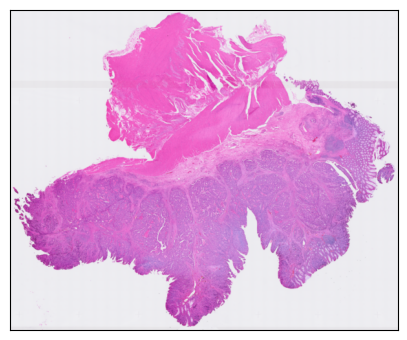

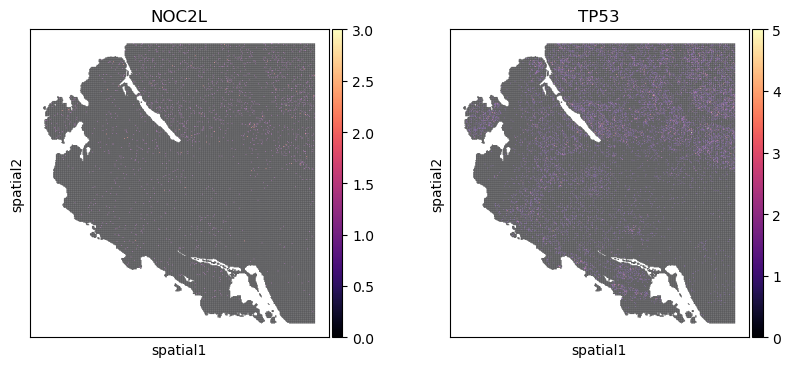

In [10]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 4)

sc.pl.spatial(hd, color=['NOC2L', 'TP53'], cmap='magma', spot_size=1)

## QC and preprocessing

The choosen resolution for 10X Visium HD bins is $8 \mu m$, this means that each spot can contain or partially overlap with one cell, or multiple cells of different identity. For this reason, contrary to `scRNA-seq` analysis, we do not perform a doublet detection step during quality control. 

Instead we compute standard QC metrics with `sc.pp.calculate_qc_metrics` and percentage of mitochondrial read counts per sample.

In [11]:
hd.var["mt"] = hd.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(hd, qc_vars=["mt"], inplace=True)

TBB Warning: The number of workers is currently limited to 0. The request for 4 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



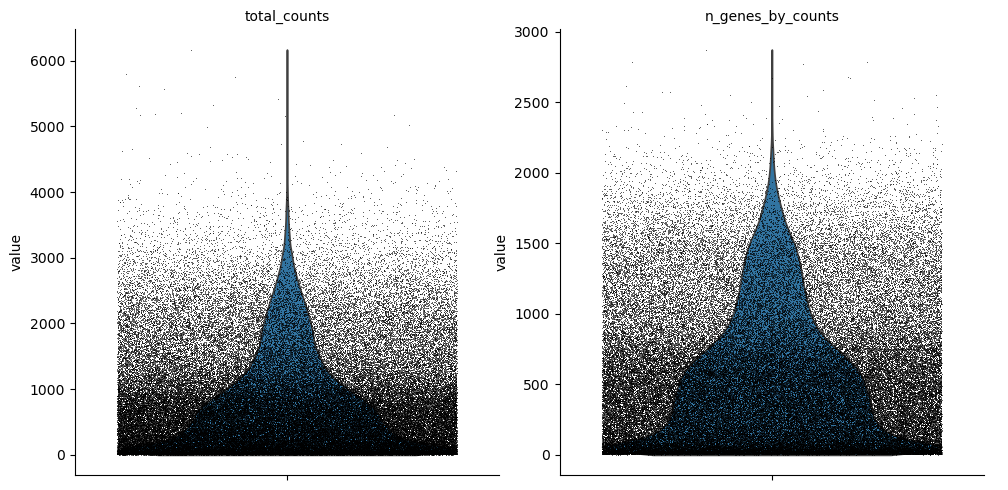

In [12]:
sc.pl.violin(hd, ['total_counts', 'n_genes_by_counts'],
             jitter=0.4, multi_panel=True, size=0.5)

/tmp/ipykernel_3102181/4175194662.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(hd, color=["total_counts", "n_genes_by_counts"], cmap='magma', spot_size=1)


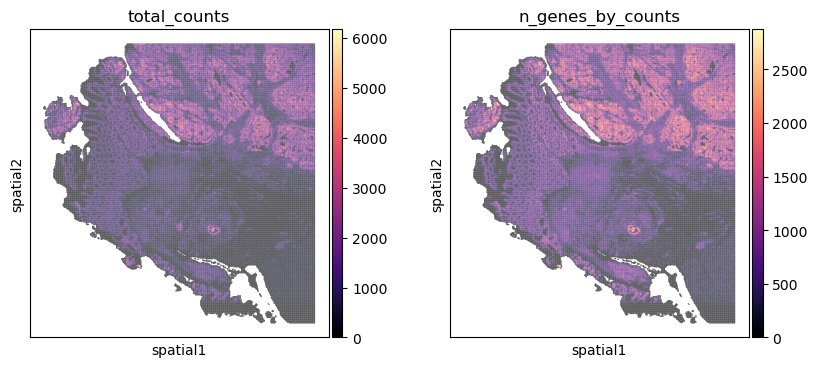

In [13]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.spatial(hd, color=["total_counts", "n_genes_by_counts"], cmap='magma', spot_size=1)

Since a single spot can partially overlap with one or multiple cells we do not heavily filter out spots with high counts because they might ovelap with dense tissue areas. We instead set a low threshold for the minimum number of genes and counts required per spot to remove low quality data, e.g. broken or empty tissue areas.

We have decided not to filter spots with high mitochondria gene counts because although they might indicate presence of broken or dying cells, we do not notice any specific tissue damage from the H&E image in areas where mitochondria gene counts are high.

In [14]:
sc.pp.filter_cells(hd, min_counts=40) # Filter spots with less than 40 counts
sc.pp.filter_cells(hd, min_genes=40) # Filter spots with less than 40 genes
sc.pp.filter_genes(hd, min_cells=100) # Filter genes expressed in less than 100 spots

/tmp/ipykernel_3102181/3356077377.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(hd, color=["total_counts", "n_genes_by_counts"], cmap='magma', spot_size=1)


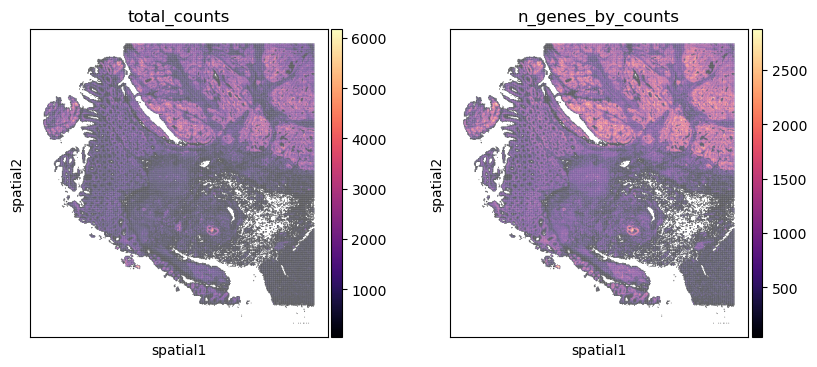

In [15]:
sc.pl.spatial(hd, color=["total_counts", "n_genes_by_counts"], cmap='magma', spot_size=1)

## Normalization
We have seen that total counts (number of UMIs) vary significantly between spots. This is mainly due to the tissue anatomy but also due to technical factors that introduce non biological variations that we wish to remove by normalizing the data with respect to total counts of UMIs per spot.

In [16]:
sc.pp.normalize_total(hd, inplace=True)
sc.pp.log1p(hd)
hd.raw = hd

## Spatially variable genes
Similarly to `scRNA-seq` data analysis, we wish to reduce the dimensionality of the dataset by identify highly-variable genes (HVGs). HVGs are genes which show significantly different expression profiles between cells or distinct groups. This kind of analysis can also be applied to spatial data, however, methods designed for this task do not take into account the spatial context and spatial relationships between cells/spots. A gene might for example be highly variable, but not show a distinct spatial pattern and is therefore not spatially variable.

In [17]:
# Find highly variable genes
sc.pp.highly_variable_genes(hd)
hvg = hd.var_names[hd.var.highly_variable==True]
hd.var[hd.var.highly_variable==True].head()

gene_ids    feature_types  genome     mt  n_cells_by_counts  \
MXRA8   ENSG00000162576  Gene Expression  GRCh38  False               7127   
MMP23B  ENSG00000189409  Gene Expression  GRCh38  False               1154   
CAMTA1  ENSG00000171735  Gene Expression  GRCh38  False               7819   
PER3    ENSG00000049246  Gene Expression  GRCh38  False               2596   
ERRFI1  ENSG00000116285  Gene Expression  GRCh38  False               4375   

        mean_counts  log1p_mean_counts  pct_dropout_by_counts  total_counts  \
MXRA8      0.063720           0.061772              94.423710        8144.0   
MMP23B     0.009358           0.009314              99.097090        1196.0   
CAMTA1     0.066529           0.064409              93.882277        8503.0   
PER3       0.020898           0.020683              97.968844        2671.0   
ERRFI1     0.037032           0.036363              96.576923        4733.0   

        log1p_total_counts  n_cells  highly_variable     means  dispersions  \
MXRA8             9.005159     7097             True  0.087322     1.102025   
MMP23B            7.087574     1141             True  0.016734     1.407187   
CAMTA1            9.048292     7798             True  0.053953     0.923536   
PER3              7.890583     2579             True  0.032794     1.194186   
ERRFI1            8.462525     4352             True  0.041975     1.116256   

        dispersions_norm  
MXRA8           1.151413  
MMP23B          2.254506  
CAMTA1          0.506216  
PER3            1.484556  
ERRFI1          1.202856

/tmp/ipykernel_3102181/1508049754.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(hd, color=['MXRA8', 'MMP23B','CAMTA1'], cmap='magma', spot_size=1)


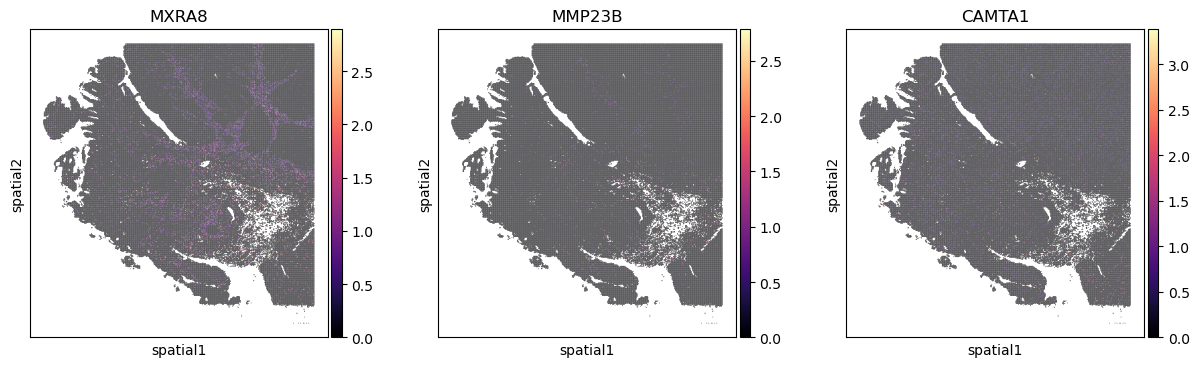

In [18]:
sc.pl.spatial(hd, color=['MXRA8', 'MMP23B','CAMTA1'], cmap='magma', spot_size=1)

In order to identify **spatially variable genes** (SVG), we need to decompose spatial and non-spatial variations in gene expression. Genes that show variatiation in gene expression predominantly due to spatial variation can be said that are spatially variable ([Walker et al., 2022](https://doi.org/10.1038/s42003-022-03175-5)).

Several methods have been proposed to identify spatially variable genes:
- SpatialDE ([Svensson et al., 2018](https://doi.org/10.1038/nmeth.4636))
- SpatialDE2 ([Kats et al., 2021](https://doi.org/10.1101/2021.10.27.466045))
- SPARK ([Zhu et al., 2021](https://doi.org/10.1186/s13059-021-02404-0))
- Sepal ([Andersson and Lundeberg, 2021](https://doi.org/10.1093/bioinformatics/btab164))
- scGCO ([Zhang et al., 2022](https://doi.org/10.1038/s41467-022-33182-3))
- SpaGCN ([Hu et al., 2021](https://doi.org/10.1038/s41592-021-01255-8))

A simple and straightfoward method to identify SVGs is to measure the spatial autocorrelation of each gene with [Moran’s I](https://en.wikipedia.org/wiki/Moran%27s_I) statistics. For this task we are going to use `Squidpy`, a complementary Python package to `Scanpy` (https://squidpy.readthedocs.io/en/stable/index.html) specifically desigin for analysing spatial data.

We first construct a spatial graph by connecting proximal spots based on their X,Y coordinates.

In [19]:
from IPython.display import Image, display

# Display the image
# display(Image('/mnt/storage/nhecker/data/spatial/VisiumHD/spatial_graph.png'))

In [20]:
import squidpy as sq

sq.gr.spatial_neighbors(hd, n_neighs=6) # Build spatial graph

/dodrio/scratch/projects/2024_301/Spatial-Omics-Data-Analysis/.miniconda3/envs/SODA/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/dodrio/scratch/projects/2024_301/Spatial-Omics-Data-Analysis/.miniconda3/envs/SODA/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)


We then compute Morans's I statistics for each gene.

In [21]:
"""from IPython.display import Image, display

# Display the image
display(Image('/mnt/storage/nhecker/data/spatial/VisiumHD/moranI.png'))"""

"from IPython.display import Image, display\n\n# Display the image\ndisplay(Image('/mnt/storage/nhecker/data/spatial/VisiumHD/moranI.png'))"

In [22]:
sq.gr.spatial_autocorr(hd, mode="moran", genes=hd.var_names) # Moran's I statistic
hd.uns["moranI"]

I  pval_norm  var_norm  pval_norm_fdr_bh
PIGR    0.877290   0.000000  0.000003          0.000000
MUC12   0.805895   0.000000  0.000003          0.000000
OLFM4   0.762097   0.000000  0.000003          0.000000
DES     0.755507   0.000000  0.000003          0.000000
REG1A   0.741066   0.000000  0.000003          0.000000
...          ...        ...       ...               ...
USP27X -0.001701   0.147955  0.000003          0.163102
THAP3  -0.001711   0.146442  0.000003          0.161508
ZNF302 -0.001792   0.135304  0.000003          0.149914
TRIM68 -0.002021   0.106985  0.000003          0.119989
ATXN1L -0.002434   0.067032  0.000003          0.076936

[14386 rows x 4 columns]

/tmp/ipykernel_3102181/1506210898.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(hd, color=['PIGR', 'REG1A', 'OLFM4'], cmap='magma', spot_size=1)


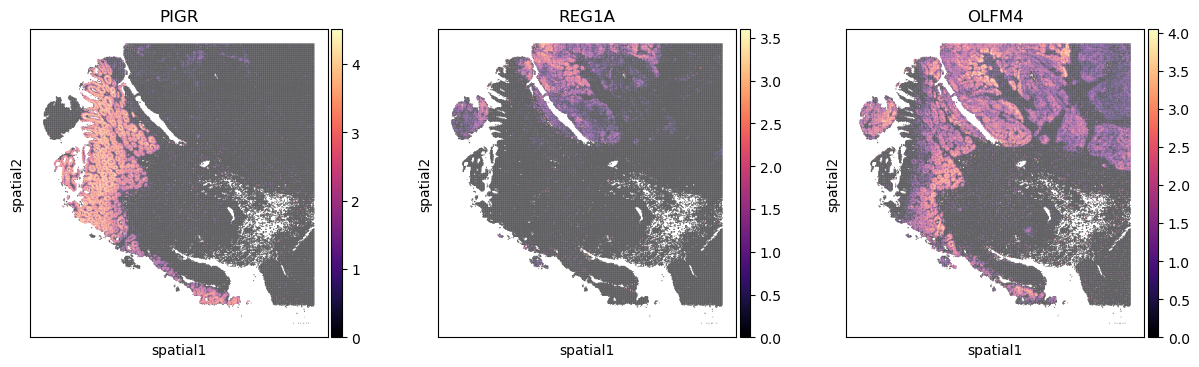

In [23]:
sc.pl.spatial(hd, color=['PIGR', 'REG1A', 'OLFM4'], cmap='magma', spot_size=1)

## Principal components on spatially variable genes

We can compute principal component analysis based on SVG to extract spatially varing components that most likely represent gene programs active in different tissue areas.

We first define SVGs by setting a threhsold on the Moran's I score.

In [24]:
svg = hd.uns["moranI"][hd.uns["moranI"].I>0.3].index.to_list()
hd.var.highly_variable = hd.var_names.isin(svg)

We then compute PCA on the SVG and visualize the principal components and their loadings. We first save log-normalized values in `hd.log_norm`

In [25]:
# # save log-normalized expression values
# hd.log_norm = hd

sc.pp.scale(hd)
sc.pp.pca(hd, n_comps=50, use_highly_variable=True)

/dodrio/scratch/projects/2024_301/Spatial-Omics-Data-Analysis/.miniconda3/envs/SODA/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/dodrio/scratch/projects/2024_301/Spatial-Omics-Data-Analysis/.miniconda3/envs/SODA/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


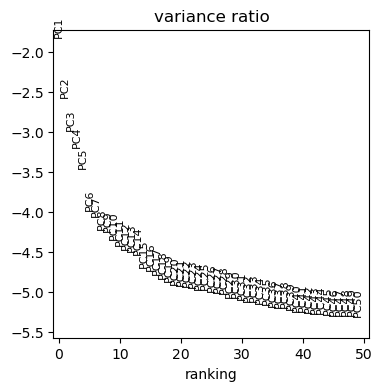

In [26]:
sc.pl.pca_variance_ratio(hd, log=True, n_pcs=50)

In [27]:
import pandas as pd
import numpy as np

hd.obs = hd.obs.join(pd.DataFrame(hd.obsm['X_pca'], index=hd.obs.index, columns=['PC'+str(x+1) for x in np.arange(hd.varm['PCs'].shape[1])]))

/tmp/ipykernel_3102181/1243902157.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(hd, color=['PC1', 'PC2', 'PC3'], cmap='bwr', vcenter=0, spot_size=1)


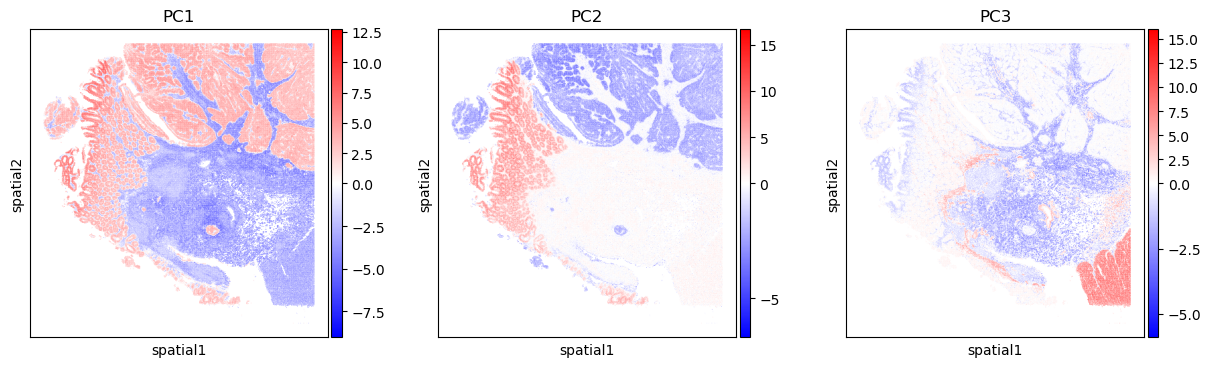

In [28]:
sc.pl.spatial(hd, color=['PC1', 'PC2', 'PC3'], cmap='bwr', vcenter=0, spot_size=1)

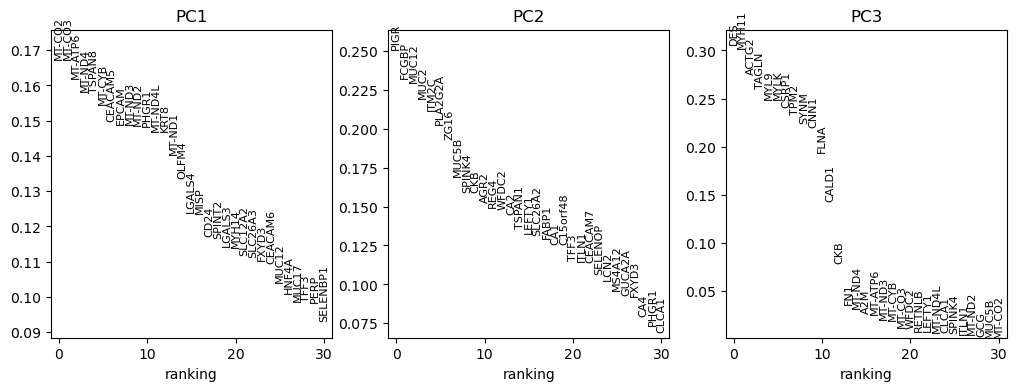

In [29]:
sc.pl.pca_loadings(hd, include_lowest=False)

## Spatial domains
We can now explore how tissue architecture is spatially defined in different compartments with different gene expression and cell-type composition. We first compute the gene expression and spatial neighborhood graph.

In [30]:
# nearest neighbor graph
sc.pp.neighbors(hd, use_rep='X_pca')
nn_graph_genes = hd.obsp["connectivities"]

# spatial proximity graph
sq.gr.spatial_neighbors(hd)
nn_graph_space = hd.obsp["spatial_connectivities"]

/dodrio/scratch/projects/2024_301/Spatial-Omics-Data-Analysis/.miniconda3/envs/SODA/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We then cluster the gene expression using leiden clustering.

In [31]:
# Run leiden clustering
sc.tl.leiden(hd, resolution=2, adjacency=nn_graph_genes, key_added="leiden")

/tmp/ipykernel_3102181/608310270.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(hd, resolution=2, adjacency=nn_graph_genes, key_added="leiden")


Obtained clusters represent cell-type specific gene expression programs localized in different tissue areas.

/tmp/ipykernel_3102181/3295524469.py:6: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(hd, color=["leiden"], show=True, spot_size=1)


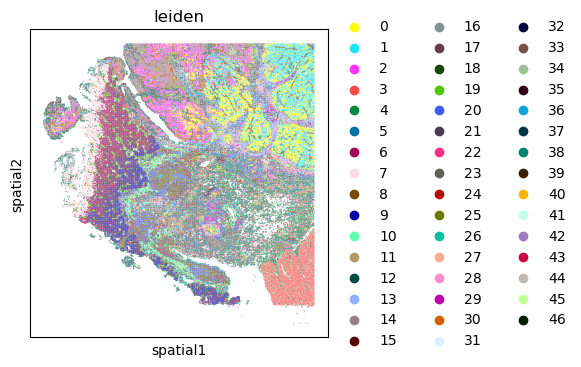

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage

sc.pl.spatial(hd, color=["leiden"], show=True, spot_size=1)


To find broader anotomical tissue domains we can blend the neighborhood graph in pca space with the spatial neighborhood graph in spatial coordinates.


In [33]:
# Blend neighborhood and spatial neighborhood graph 
alpha = 0.5
joint_graph = (1 - alpha) * nn_graph_genes + alpha * nn_graph_space
# Run leiden clustering
sc.tl.leiden(hd, resolution=2, adjacency=joint_graph, key_added="spatial_domains")

/tmp/ipykernel_3102181/201547390.py:6: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(hd, color=["spatial_domains"], show=True, spot_size=1)


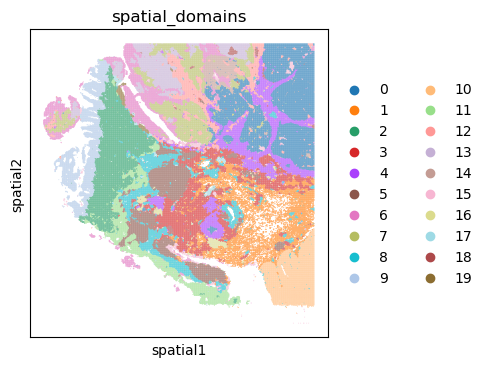

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


sc.pl.spatial(hd, color=["spatial_domains"], show=True, spot_size=1)
plt.show()

More advanced methods to cluster spatial data are broadly available in literature, here are some examples:
- [Clustermap](https://doi.org/10.1038/s41467-021-26044-x)
- [spaGCN](https://doi.org/10.1038/s41592-021-01255-8)
- [stLearn](https://doi.org/10.1101/2020.05.31.125658)
- [BayesSpace](https://doi.org/10.1038/s41587-021-00935-2)
- [SpatialGlue](https://doi.org/10.1038/s41592-024-02316-4)
- [TopACT](https://doi.org/10.1038/s41586-024-07563-1)

We can now compute marker genes for these clusters to help us understand their cell-type composition and annotate the different tissue regions.

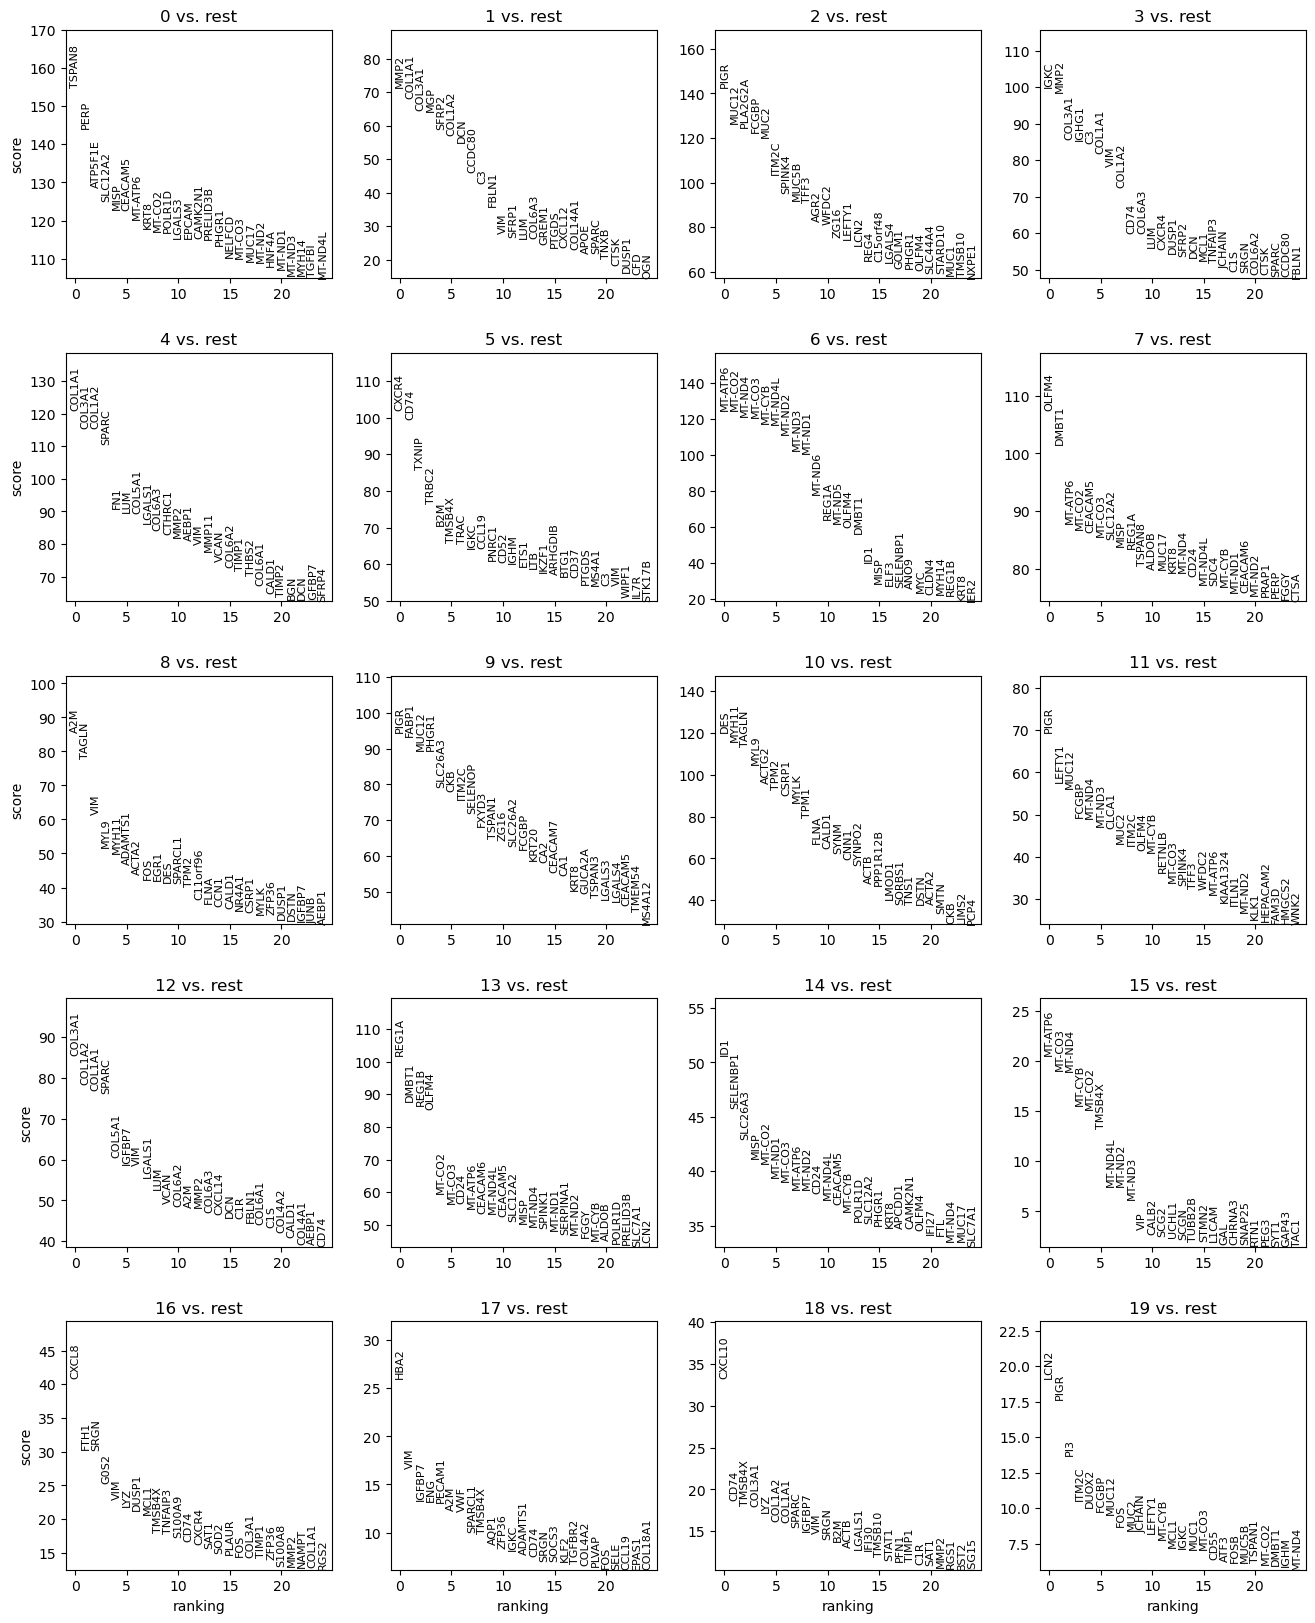

: 

In [ ]:
sc.tl.rank_genes_groups(hd, 'spatial_domains', method='wilcoxon', use_raw=True)
sc.pl.rank_genes_groups(hd, n_genes=25, sharey=False)

## Load data
The data is in the [anndata](https://anndata.readthedocs.io/en/latest/) format.
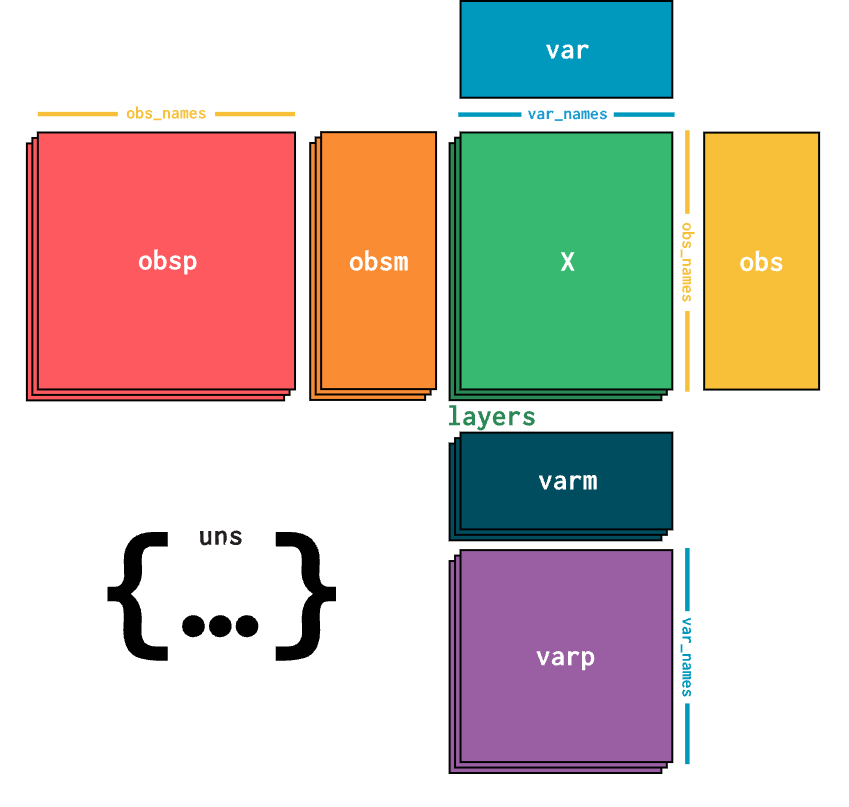